In [ ]:
import time
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import torch
from torch import nn

from skimage.transform import resize
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Seed

In [ ]:
seed_number = 44
torch.manual_seed(seed_number)
torch.cuda.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed_number)
random.seed(seed_number)

# Data Load

In [ ]:
#ds_t = xr.open_dataset('./tmax.nc')
#ds_p = xr.open_dataset('./prec.nc')
#ds_kbdi = xr.open_dataset('./PISCO_KBDI_update.nc')

ds_t = xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset('./tmax.nc', 'r')))
ds_p = xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset('./prec.nc', 'r')))
#ds_kbdi = xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset('./PISCO_KBDI_update.nc', 'r')))

In [ ]:
ds_t

<xarray.Dataset> Size: 2GB
Dimensions:  (T: 13149, Y: 202, X: 145)
Coordinates:
  * T        (T) datetime64[ns] 105kB 1981-01-01T12:00:00 ... 2016-12-31T12:0...
  * Y        (Y) float32 808B 1.35 1.25 1.15 1.05 ... -18.55 -18.65 -18.75
  * X        (X) float32 580B -81.45 -81.35 -81.25 ... -67.25 -67.15 -67.05
Data variables:
    tmax     (T, Y, X) float32 2GB ...

In [ ]:
ds_p

<xarray.Dataset> Size: 1GB
Dimensions:  (T: 13149, Y: 198, X: 133)
Coordinates:
  * T        (T) datetime64[ns] 105kB 1981-01-01T12:00:00 ... 2016-12-31T12:0...
  * Y        (Y) float32 792B 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * X        (X) float32 532B -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
Data variables:
    Prec     (T, Y, X) float32 1GB ...

In [ ]:
#ds_kbdi

<xarray.Dataset> Size: 1GB
Dimensions:  (T: 13149, Y: 198, X: 133)
Coordinates:
  * T        (T) datetime64[ns] 105kB 1981-01-01T12:00:00 ... 2016-12-31T12:0...
  * Y        (Y) float32 792B 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * X        (X) float32 532B -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
Data variables:
    kbdi     (T, Y, X) float32 1GB ...

In [ ]:
ds_t['tmax'].sel(T=slice('1983-01-01', '2016-12-31'),Y=slice(1., -18.75), X=slice(-81.25,-68.05))

<xarray.DataArray 'tmax' (T: 12419, Y: 198, X: 133)> Size: 1GB
[327041946 values with dtype=float32]
Coordinates:
  * T        (T) datetime64[ns] 99kB 1983-01-01T12:00:00 ... 2016-12-31T12:00:00
  * Y        (Y) float32 792B 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * X        (X) float32 532B -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
Attributes:
    long_name:       Maximum Temperature
    units:           Celsius_scale
    colorscalename:  temp_colors
    ncolor:          254
    colormap:        [null 7208960 7208960 8519680 [8519680 15] 11146260 [111...
    maxncolor:       254

In [ ]:
t = ds_t['tmax'].sel(T=slice('1983-01-01', '2016-12-31'),Y=slice(1., -18.75), X=slice(-81.25,-68.05))
p = ds_p['Prec'].sel(T=slice('1983-01-01', '2016-12-31'))
#k = ds_kbdi['kbdi'].sel(T=slice('1983-01-01', '2016-12-31'))

print(t.shape, p.shape, k.shape)

(12419, 198, 133) (12419, 198, 133) (12419, 198, 133)


In [ ]:
t = t.as_numpy()[:,1:-1,2:-3]
p = p.as_numpy()[:,1:-1,2:-3]
#k = k.as_numpy()[:,1:-1,2:-3]

#print(t.shape, p.shape, k.shape)
print(t.shape, p.shape)

(12419, 196, 128) (12419, 196, 128) (12419, 196, 128)


In [ ]:
k = np.load('./k.npy')
print(k.shape)

# Downsampling (interpolation)

In [ ]:
t_d, p_d, k_d = [], [], []

for i in tqdm(range(len(t))):
    t_d.append(resize(t[i], (98, 64)))
    p_d.append(resize(p[i], (98, 64)))
    k_d.append(resize(k[i], (98, 64)))

t_d = np.stack(t_d, axis=0)
p_d = np.stack(p_d, axis=0)
k_d = np.stack(k_d, axis=0)

print(t_d.shape, p_d.shape, k_d.shape)

100%|██████████| 12419/12419 [00:31<00:00, 395.64it/s]


(12419, 98, 64) (12419, 98, 64) (12419, 98, 64)


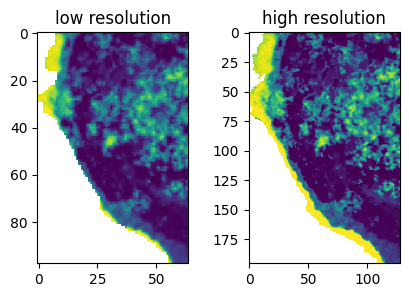

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
ax[0].imshow(k_d[1000], vmin=0, vmax=200)
ax[1].imshow(k[1000],   vmin=0, vmax=200)

ax[0].set_title('low resolution')
ax[1].set_title('high resolution')
plt.show()

# Data Preprocessing

In [ ]:
# add channel dimension
t_d = np.expand_dims(t_d, axis=1)
p_d = np.expand_dims(p_d, axis=1)

k_d = np.expand_dims(k_d, axis=1)
k   = np.expand_dims(k, axis=1)

print(t_d.shape, p_d.shape, k_d.shape)
print(k.shape)

(12419, 1, 98, 64) (12419, 1, 98, 64) (12419, 1, 98, 64)
(12419, 1, 196, 128)


In [ ]:
# fill up NaN values (ocean -> 0)
t_d[np.isnan(t_d)] = 0.
p_d[np.isnan(p_d)] = 0.
k_d[np.isnan(k_d)] = 0.
k[np.isnan(k)] = 0.

In [ ]:
# 0 ~ 203.2 -> 0 ~ 1
k /= 203.2
k_d /= 203.2

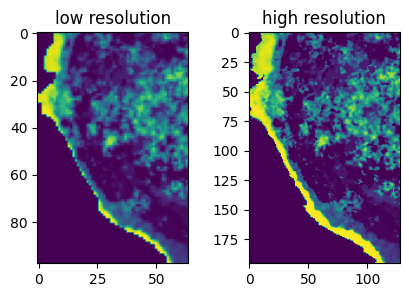

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
ax[0].imshow(k_d[1000,0], vmin=0, vmax=1)
ax[1].imshow(k[1000,0],   vmin=0, vmax=1)

ax[0].set_title('low resolution')
ax[1].set_title('high resolution')
plt.show()

# Split Data

In [ ]:
date_idx = pd.date_range('1983-01-02', '2016-12-31', freq='1d')

tr_idx, ts_idx = [], []
for i, date in enumerate(date_idx):
    if date.year % 10 == 6:     # test set : 1986, 1996, 2006, 2016
        ts_idx.append(i)
    else:
        tr_idx.append(i)

In [ ]:
X_t, X_t_ts = t_d[tr_idx], t_d[ts_idx]
X_p, X_p_ts = p_d[tr_idx], p_d[ts_idx]
X_k, X_k_ts = k_d[tr_idx], k_d[ts_idx]

Y, Y_ts = k[tr_idx], k[ts_idx]

print(X_t.shape, X_p.shape, X_k.shape, Y.shape)
print(X_t_ts.shape, X_p_ts.shape, X_k_ts.shape, Y_ts.shape)

(10956, 1, 98, 64) (10956, 1, 98, 64) (10956, 1, 98, 64) (10956, 1, 196, 128)
(1462, 1, 98, 64) (1462, 1, 98, 64) (1462, 1, 98, 64) (1462, 1, 196, 128)


# Normalize

In [ ]:
def minmax_norm(x, x_ts, var=None):
    x_min, x_max = np.nanmin(x), np.nanmax(x)
    print(var, x_min, x_max)

    x_    = (x    - x_min) / (x_max - x_min + 1e-10)
    x_ts_ = (x_ts - x_min) / (x_max - x_min + 1e-10)
    return x_, x_ts_

In [ ]:
X_t, X_t_ts = minmax_norm(X_t, X_t_ts, var='t2m')
X_p, X_p_ts = minmax_norm(X_p, X_p_ts, var='rain')
X_k, X_k_ts = minmax_norm(X_k, X_k_ts, var='kbdi')

t2m 0.0 41.16606
rain 0.0 413.0206
kbdi 0.0 0.99999624


In [ ]:
X    = np.concatenate([X_t, X_p, X_k], axis=1)
X_ts = np.concatenate([X_t_ts, X_p_ts, X_k_ts], axis=1)

print(X.shape, Y.shape)
print(X_ts.shape, Y_ts.shape)

(10956, 3, 98, 64) (10956, 1, 196, 128)
(1462, 3, 98, 64) (1462, 1, 196, 128)


# Model

In [ ]:
def conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        act = nn.ReLU(True)

        # head module
        m_head = [conv(3, 64, 3), act]

        # body module
        m_body = [conv(64, 64, 3), act]

        # tail module
        m_tail = [conv(64, 64*(2**2), 3), nn.PixelShuffle(2), conv(64, 1, 3)]

        self.head = nn.Sequential(*m_head)
        self.body = nn.Sequential(*m_body)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, xb):
        out = self.head(xb)
        out = self.body(out)
        out = self.tail(out)
        return out

# Training

cuda
Epoch 1 Loss => train:0.06333, valid:0.03751, Elapsed time => 11.164 sec


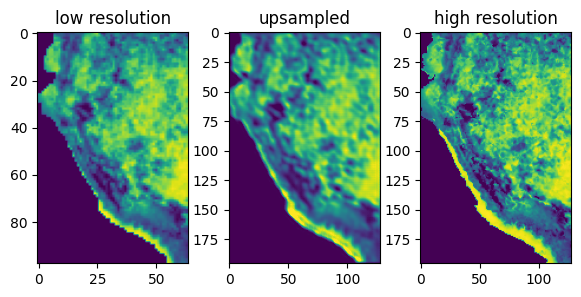

Epoch 2 Loss => train:0.03164, valid:0.02890, Elapsed time => 10.794 sec
Epoch 3 Loss => train:0.02624, valid:0.02746, Elapsed time => 10.713 sec
Epoch 5 Loss => train:0.02423, valid:0.02292, Elapsed time => 10.689 sec
Epoch 6 Loss => train:0.02220, valid:0.02222, Elapsed time => 10.751 sec
Epoch 9 Loss => train:0.02126, valid:0.02208, Elapsed time => 10.736 sec
Epoch 10 Loss => train:0.02107, valid:0.02147, Elapsed time => 9.797 sec
Epoch 11 Loss => train:0.02074, valid:0.02075, Elapsed time => 7.443 sec
Epoch 13 Loss => train:0.02051, valid:0.02046, Elapsed time => 7.451 sec
Epoch 14 Loss => train:0.02032, valid:0.02044, Elapsed time => 7.492 sec
Epoch 17 Loss => train:0.01965, valid:0.02023, Elapsed time => 10.726 sec


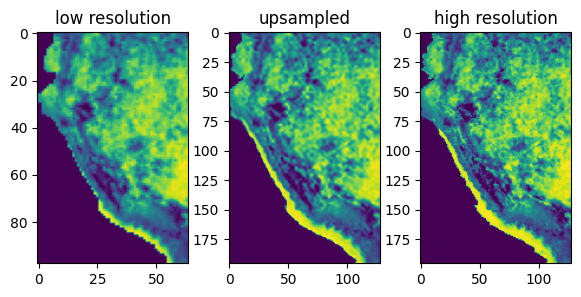

Epoch 18 Loss => train:0.02065, valid:0.01976, Elapsed time => 10.694 sec
Epoch 19 Loss => train:0.01928, valid:0.01948, Elapsed time => 10.716 sec
Epoch 20 Loss => train:0.01923, valid:0.01939, Elapsed time => 10.739 sec
Epoch 22 Loss => train:0.01975, valid:0.01931, Elapsed time => 10.748 sec
Epoch 23 Loss => train:0.01887, valid:0.01902, Elapsed time => 10.721 sec
Epoch 24 Loss => train:0.01904, valid:0.01902, Elapsed time => 10.668 sec
Epoch 25 Loss => train:0.01881, valid:0.01884, Elapsed time => 10.743 sec
Epoch 28 Loss => train:0.01867, valid:0.01865, Elapsed time => 10.722 sec
Epoch 30 Loss => train:0.01860, valid:0.01854, Elapsed time => 10.682 sec
Epoch 31 Loss => train:0.01835, valid:0.01838, Elapsed time => 10.712 sec


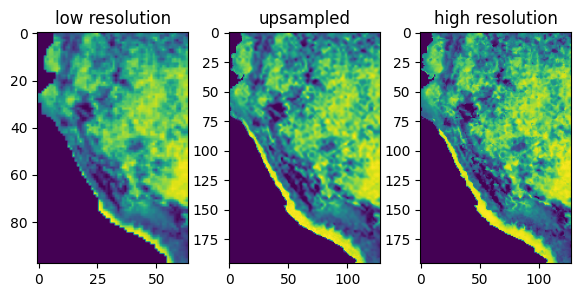

Epoch 33 Loss => train:0.01832, valid:0.01833, Elapsed time => 10.696 sec
Epoch 36 Loss => train:0.01816, valid:0.01824, Elapsed time => 10.686 sec
Epoch 38 Loss => train:0.01800, valid:0.01806, Elapsed time => 10.641 sec
Epoch 41 Loss => train:0.01783, valid:0.01802, Elapsed time => 7.489 sec
Epoch 44 Loss => train:0.01780, valid:0.01802, Elapsed time => 7.477 sec
Epoch 46 Loss => train:0.01772, valid:0.01786, Elapsed time => 10.695 sec
Epoch 49 Loss => train:0.01759, valid:0.01769, Elapsed time => 10.676 sec
Epoch 54 Loss => train:0.01738, valid:0.01759, Elapsed time => 10.606 sec
Epoch 57 Loss => train:0.01738, valid:0.01751, Elapsed time => 10.608 sec
Epoch 63 Loss => train:0.01720, valid:0.01746, Elapsed time => 10.697 sec


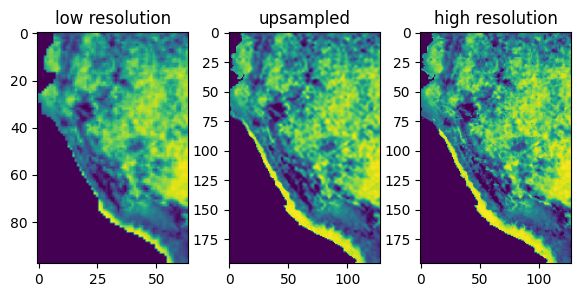

Epoch 64 Loss => train:0.01723, valid:0.01736, Elapsed time => 10.651 sec
Epoch 67 Loss => train:0.01712, valid:0.01732, Elapsed time => 10.641 sec
Epoch 68 Loss => train:0.01717, valid:0.01726, Elapsed time => 10.610 sec
Epoch 74 Loss => train:0.01702, valid:0.01719, Elapsed time => 9.306 sec
Epoch 75 Loss => train:0.01709, valid:0.01717, Elapsed time => 10.676 sec
Epoch 78 Loss => train:0.01697, valid:0.01716, Elapsed time => 10.591 sec
Epoch 79 Loss => train:0.01699, valid:0.01710, Elapsed time => 10.670 sec
Epoch 81 Loss => train:0.01694, valid:0.01700, Elapsed time => 10.622 sec
Epoch 84 Loss => train:0.01687, valid:0.01700, Elapsed time => 10.623 sec
Epoch 87 Loss => train:0.01683, valid:0.01697, Elapsed time => 10.589 sec


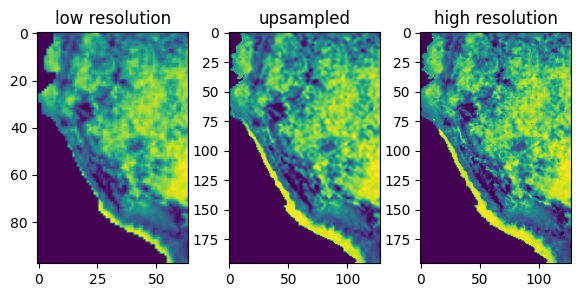

Epoch 88 Loss => train:0.01683, valid:0.01696, Elapsed time => 10.690 sec
Epoch 94 Loss => train:0.01674, valid:0.01694, Elapsed time => 10.635 sec
Epoch 96 Loss => train:0.01675, valid:0.01688, Elapsed time => 10.640 sec
Epoch 102 Loss => train:0.01664, valid:0.01676, Elapsed time => 7.485 sec
Epoch 105 Loss => train:0.01663, valid:0.01674, Elapsed time => 10.641 sec
Epoch 109 Loss => train:0.01664, valid:0.01672, Elapsed time => 10.633 sec
Epoch 110 Loss => train:0.01661, valid:0.01672, Elapsed time => 10.648 sec
Epoch 115 Loss => train:0.01651, valid:0.01666, Elapsed time => 10.638 sec
Epoch 117 Loss => train:0.01654, valid:0.01664, Elapsed time => 10.599 sec
Epoch 125 Loss => train:0.01647, valid:0.01658, Elapsed time => 10.595 sec


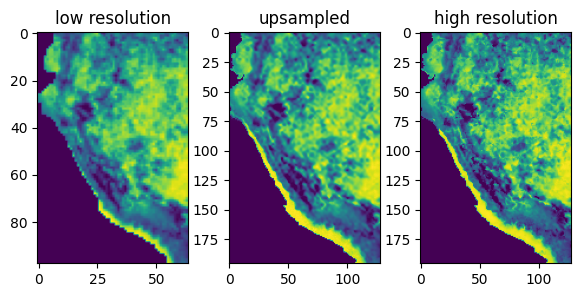

Epoch 135 Loss => train:0.01638, valid:0.01653, Elapsed time => 10.646 sec
Epoch 141 Loss => train:0.01642, valid:0.01652, Elapsed time => 10.617 sec
Epoch 145 Loss => train:0.01629, valid:0.01650, Elapsed time => 10.624 sec
Epoch 150 Loss => train:0.01628, valid:0.01643, Elapsed time => 10.564 sec
Epoch 166 Loss => train:0.01619, valid:0.01641, Elapsed time => 10.618 sec
Epoch 174 Loss => train:0.01614, valid:0.01640, Elapsed time => 10.647 sec
Epoch 180 Loss => train:0.01612, valid:0.01627, Elapsed time => 10.552 sec
Epoch 195 Loss => train:0.01616, valid:0.01623, Elapsed time => 10.662 sec
Epoch 198 Loss => train:0.01603, valid:0.01623, Elapsed time => 10.607 sec
Epoch 206 Loss => train:0.01608, valid:0.01622, Elapsed time => 10.637 sec


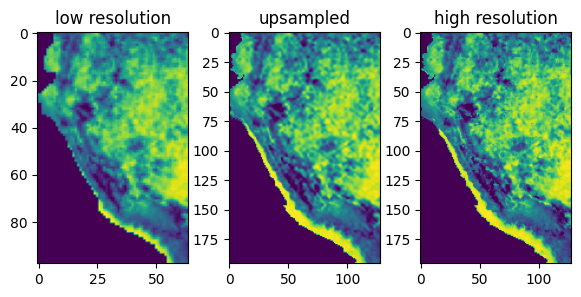

Epoch 209 Loss => train:0.01598, valid:0.01622, Elapsed time => 10.613 sec
Epoch 219 Loss => train:0.01598, valid:0.01616, Elapsed time => 7.379 sec
Epoch 226 Loss => train:0.01597, valid:0.01610, Elapsed time => 10.640 sec
Epoch 248 Loss => train:0.01588, valid:0.01608, Elapsed time => 7.465 sec
Epoch 252 Loss => train:0.01590, valid:0.01607, Elapsed time => 10.648 sec
Epoch 264 Loss => train:0.01582, valid:0.01602, Elapsed time => 10.633 sec
Epoch 279 Loss => train:0.01579, valid:0.01597, Elapsed time => 7.321 sec
Epoch 306 Loss => train:0.01611, valid:0.01594, Elapsed time => 5.088 sec
Epoch 307 Loss => train:0.01567, valid:0.01593, Elapsed time => 5.085 sec
Epoch 311 Loss => train:0.01571, valid:0.01592, Elapsed time => 5.076 sec


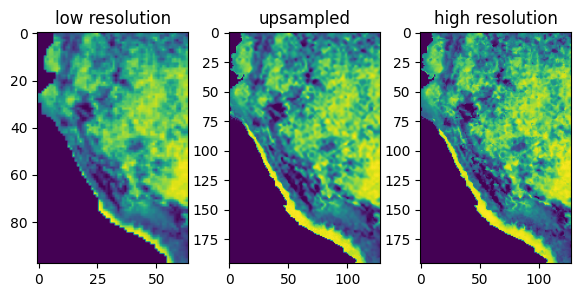

Epoch 318 Loss => train:0.01571, valid:0.01591, Elapsed time => 5.067 sec
Epoch 329 Loss => train:0.01570, valid:0.01587, Elapsed time => 5.069 sec
Epoch 344 Loss => train:0.01567, valid:0.01587, Elapsed time => 5.082 sec
Epoch 357 Loss => train:0.01565, valid:0.01584, Elapsed time => 5.070 sec
Epoch 358 Loss => train:0.01563, valid:0.01584, Elapsed time => 5.071 sec
Epoch 386 Loss => train:0.01564, valid:0.01583, Elapsed time => 5.079 sec
Epoch 388 Loss => train:0.01557, valid:0.01582, Elapsed time => 5.066 sec
Epoch 396 Loss => train:0.01564, valid:0.01582, Elapsed time => 5.068 sec
Epoch 406 Loss => train:0.01552, valid:0.01575, Elapsed time => 5.062 sec
Epoch 443 Loss => train:0.01547, valid:0.01571, Elapsed time => 5.086 sec


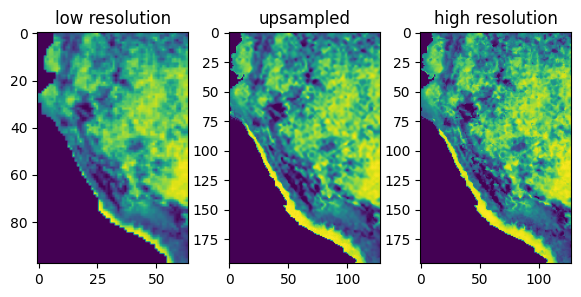

Epoch 454 Loss => train:0.01548, valid:0.01570, Elapsed time => 5.067 sec
Epoch 471 Loss => train:0.01547, valid:0.01569, Elapsed time => 5.061 sec
Epoch 478 Loss => train:0.01545, valid:0.01568, Elapsed time => 5.063 sec
Epoch 484 Loss => train:0.01545, valid:0.01566, Elapsed time => 5.064 sec
Epoch 517 Loss => train:0.01542, valid:0.01565, Elapsed time => 5.060 sec
Epoch 529 Loss => train:0.01543, valid:0.01563, Elapsed time => 5.060 sec
Epoch 551 Loss => train:0.01559, valid:0.01562, Elapsed time => 5.061 sec
Epoch 570 Loss => train:0.01538, valid:0.01561, Elapsed time => 5.061 sec
Epoch 595 Loss => train:0.01535, valid:0.01558, Elapsed time => 5.086 sec
Epoch 596 Loss => train:0.01533, valid:0.01558, Elapsed time => 5.072 sec


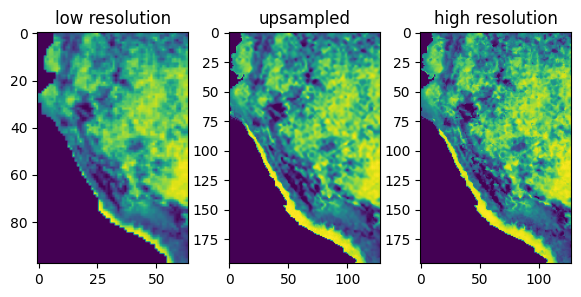

Epoch 626 Loss => train:0.01533, valid:0.01555, Elapsed time => 9.114 sec
Epoch 647 Loss => train:0.01532, valid:0.01555, Elapsed time => 9.805 sec
Epoch 655 Loss => train:0.01530, valid:0.01553, Elapsed time => 7.692 sec


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

train_loss_history, valid_loss_history = [], []
X_tr, X_vl, y_tr, y_vl = train_test_split(X, Y, test_size=0.2, random_state=44)

X_tr = torch.FloatTensor(X_tr)
X_vl = torch.FloatTensor(X_vl)
y_tr = torch.FloatTensor(y_tr)
y_vl = torch.FloatTensor(y_vl)

train_ds = torch.utils.data.TensorDataset(X_tr, y_tr)
valid_ds = torch.utils.data.TensorDataset(X_vl, y_vl)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=64, shuffle=False)

# model initialization
model = Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = torch.nn.L1Loss().to(device)

### training
is_train = True
epoch, early_stopping, monitoring = 0, 0, 0
train_loss_history_, valid_loss_history_ = [], []

while is_train:
    start = time.time()
    train_loss, train_count = 0., 0.
    epoch += 1
    early_stopping += 1

    for xb, yb in train_loader:
        xb = xb.to(device=device)
        yb = yb.to(device=device)

        yhat = model(xb)
        loss  = criterion(yhat, yb)
        train_loss += loss.item()*len(yb)
        train_count += len(yb)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss, valid_count = 0., 0.

        for xb, yb in valid_loader:
            xb = xb.to(device=device)
            yb = yb.to(device=device)

            yhat = model(xb)
            loss = criterion(yhat, yb)
            valid_loss += loss.item()*len(yb)
            valid_count += len(yb)

    train_loss /= train_count
    valid_loss /= valid_count

    train_loss_history_.append(train_loss)
    valid_loss_history_.append(valid_loss)

    if min(valid_loss_history_) == valid_loss:
        print(f"Epoch {epoch} Loss => train:{train_loss:.5f}, valid:{valid_loss:.5f}, Elapsed time => {time.time()-start:.3f} sec")
        early_stopping = 0
        monitoring += 1

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss,
        }, f'./SR_ESPCN_x2.pt')

        if monitoring % 10 == 1:
            xb   = xb[0,-1,:,:].cpu().detach().numpy()
            yhat = yhat[0,0,:,:].cpu().detach().numpy()
            yb   = yb[0,0,:,:].cpu().detach().numpy()
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7, 3))
            ax[0].imshow(xb,   vmin=0, vmax=1)
            ax[1].imshow(yhat, vmin=0, vmax=1)
            ax[2].imshow(yb,   vmin=0, vmax=1)
            ax[0].set_title('low resolution')
            ax[1].set_title('upsampled')
            ax[2].set_title('high resolution')
            plt.show()

    if early_stopping == 50:
        is_train = False

train_loss_history.append(train_loss_history_)
valid_loss_history.append(valid_loss_history_)

# Evaluation

In [ ]:
X_ts = torch.FloatTensor(X_ts)
y_ts = torch.FloatTensor(Y_ts)

test_ds = torch.utils.data.TensorDataset(X_ts, y_ts)
test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False)

# model initialization
model = Net().to(device)

model.eval()
checkpoint = torch.load(f'./SR_ESPCN_x2.pt')
model.load_state_dict(checkpoint['model_state_dict'])

results = []
with torch.no_grad():
    test_loss, test_count = 0., 0.
    for xb, yb in test_loader:
        xb = xb.to(device=device)
        yb = yb.to(device=device)

        yhat = model(xb)
        loss = criterion(yhat, yb)
        test_loss += loss.item()*len(yb)
        test_count += len(yb)

        results.append(yhat.detach().cpu().numpy())
    test_loss /= test_count
    print(test_loss)
results = np.concatenate(results, axis=0)
print(results.shape)

0.015584259430295629
(1462, 1, 196, 128)


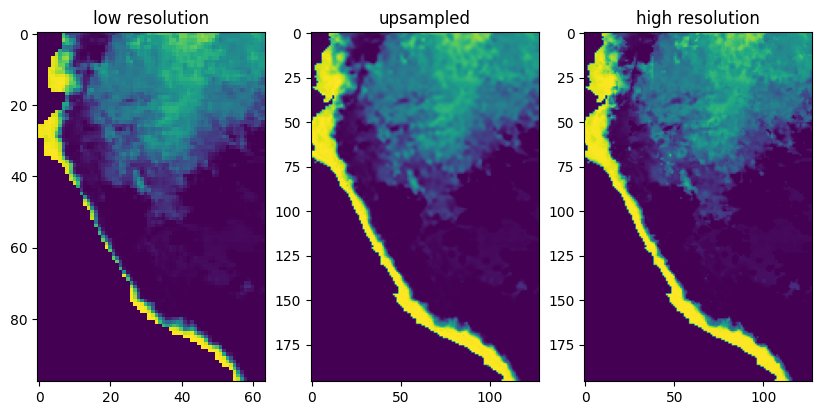

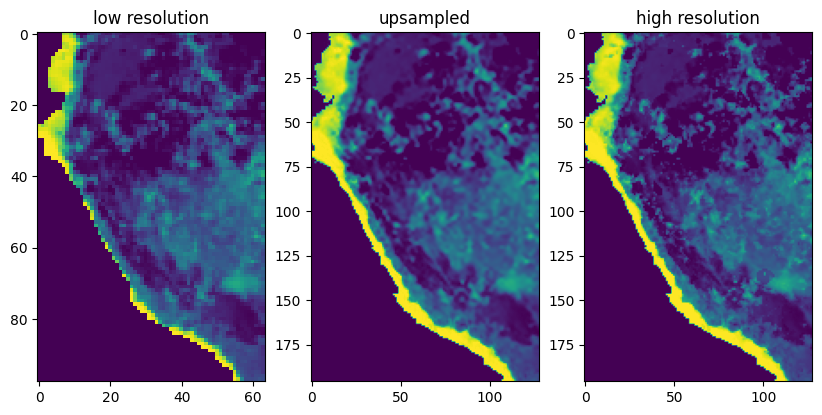

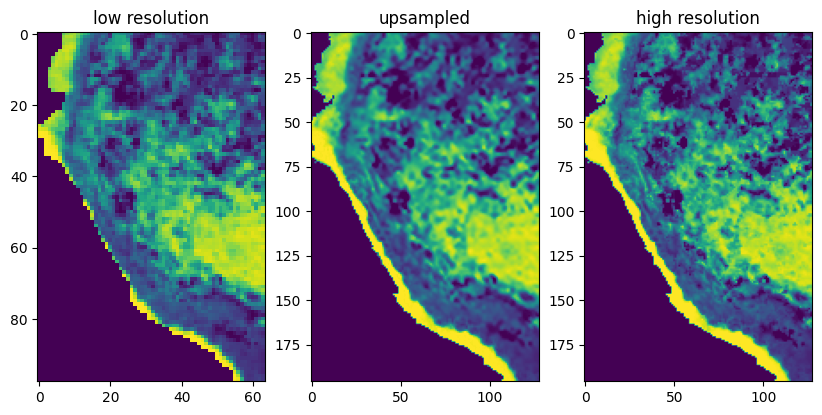

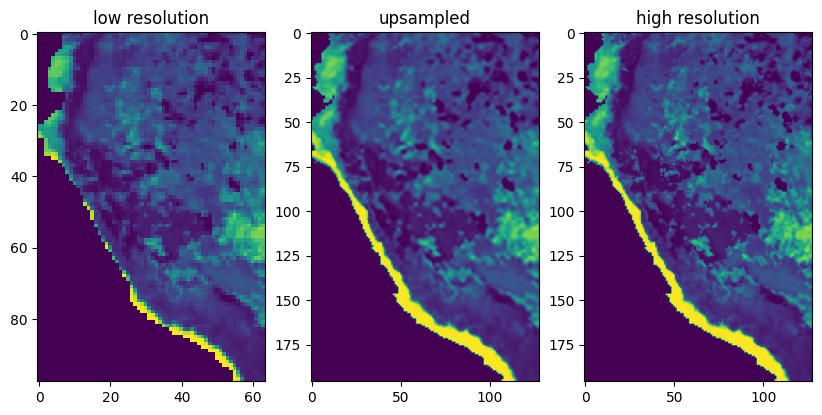

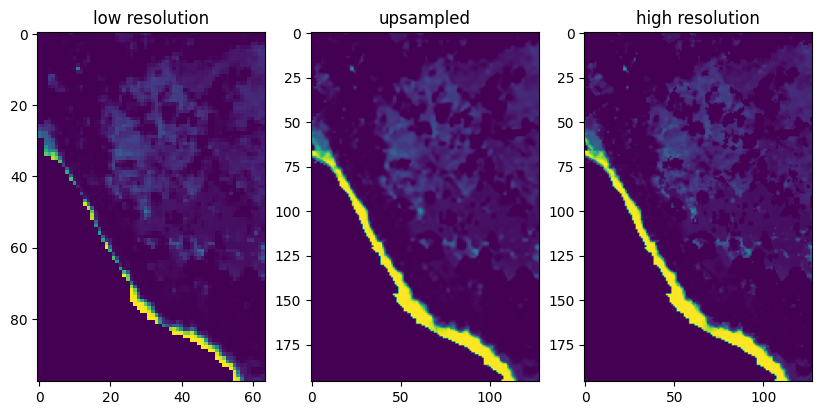

In [ ]:
for i in range(0,1400,300):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,20))
    ax[0].imshow(X_ts[i,-1]*203.2,   vmin=0, vmax=203.2)
    ax[1].imshow(results[i,0]*203.2, vmin=0, vmax=203.2)
    ax[2].imshow(Y_ts[i,0]*203.2,   vmin=0, vmax=203.2)

    ax[0].set_title('low resolution')
    ax[1].set_title('upsampled')
    ax[2].set_title('high resolution')
    plt.show()